## Brain-MDD Project
- Capstone Project

In [106]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

In [177]:
# Get the path to the EEG data and report
eegPath = os.getenv("EEG_DIR_PATH")
rawDataPath = os.getenv("EEG_DIR_PATH") + "/raw"
eeg16ChannelPath = os.getenv("EEG_DIR_PATH") + "/16channels"
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
reportPath = os.getenv("EEG_REPORT_PATH")

report = pd.read_excel(reportPath)
reportDf = pd.DataFrame(report)
# cast the subject id to string
reportDf["subject id"] = reportDf["subject id"].astype(str)
print(type(reportDf["subject id"][0]))

<class 'str'>


## Preprocessing
- Channel selection
- 5th-Order Butterworth bandpass filter
- ICA (next sprint)
- save as .fif file format + map with label

In [ ]:
for file in os.listdir(rawDataPath):
    if file.endswith(".npy"):
        data = np.load(rawDataPath + "/" + file)
        selectedChannelsEeg = []
        for channel in ChannelMapping:
            selectedChannelsEeg.append(data[channel.value])
        selectedChannelsEeg = np.array(selectedChannelsEeg)
        print(selectedChannelsEeg.shape)
        np.save(eegPath + "/16channels/" + file, selectedChannelsEeg)

In [ ]:
channelNames = [channel.name for channel in ChannelMapping]
channelTypes = ["eeg"] * len(channelNames)
sfreq = 250


for eeg16ChannelFile in os.listdir(eeg16ChannelPath):
    if eeg16ChannelFile.endswith(".npy"):
        data = np.load(eeg16ChannelPath + "/" + eeg16ChannelFile)
        info = mne.create_info(channelNames, sfreq, channelTypes)
        raw = mne.io.RawArray(data, info)
        
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage)
        
        raw.filter(0.5, 40) # Bandpass filter 0.5 - 40 Hz
        
        # ica = mne.preprocessing.ICA(n_components=16, random_state=97, max_iter=800)
        # ica.fit(raw)
        # raw = ica.apply(raw)
        eeg16ChannelFile = eeg16ChannelFile.split(".")[0]
        raw.save(eegPath + "/filtered/" + eeg16ChannelFile + ".fif", overwrite=True)

In [ ]:
# map data with labels
mddDataLst = []
controlDataLst = []

# file name is matched with the "subject id" and label is "type"
for file in os.listdir(filteredDataPath):
    if file.endswith(".fif"):
        subjectId = file.split(".")[0]
        subjectId = subjectId[1:]
        subjectId = str(subjectId)
        result = reportDf[reportDf['subject id'] == subjectId]
        if result.empty:
            continue
        label = result["type"].values[0]
        if label == "MDD":
            mddDataLst.append(subjectId)
        elif label == "HC":
            controlDataLst.append(subjectId)
        os.rename(filteredDataPath + "/" + file, filteredDataPath + "/" + subjectId + "_" + label + ".fif")

## Feature Extraction

In [179]:
filteredDataPath = os.getenv("EEG_DIR_PATH") + "/filtered"
reportPath = os.getenv("EEG_REPORT_PATH")

In [ ]:
# get psd of the data; delta, theta, alpha, beta, gamma

tempPath = filteredDataPath + "/" + "2010002_MDD.fif"
# do delta psd for this file
raw = mne.io.read_raw_fif(tempPath, preload=True)

psd_results = raw.compute_psd(
    method='welch',
    fmin=0.5, 
    fmax=4, 
    n_fft=250, 
    n_overlap=125)

psds = psd_results.get_data()
freqs = psd_results.freqs

deltaPower = np.sum(psds, axis=1)
for channel, power in zip(ChannelMapping, deltaPower):
    print(channel.name, power)

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010002_MDD.fif...
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
Reading 0 ... 75188  =      0.000 ...   300.752 secs...
Effective window size : 1.000 (s)
Fp1 52.375162657262685
Fp2 55.552494429370796
F3 169.53949735519936
F4 68.12839797561358
C3 7.280407881390322
C4 16.218952043857275
P3 8.1278531070454
P4 13.401242441071807
O1 22.66066360206606
O2 19.226636485941043
F7 41.99716968486356
F8 45.367069636612456
T3 13.391390717511259
T4 24.59339749494078
T5 17.942261765488304
T6 30.28313018380323


/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/3895840086.py:10: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010002_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(tempPath, preload=True)


In [ ]:
# for loop extract the delta power for every file
deltaPsdFeatures = {
    "MDD": [],
    "HC": []
}

for file in os.listdir(filteredDataPath):
    if file.endswith(".fif"):
        raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
        psd_results = raw.compute_psd(
            method='welch',
            fmin=0.5, 
            fmax=4, 
            n_fft=250, 
            n_overlap=125)
        psds = psd_results.get_data()
        freqs = psd_results.freqs
        deltaPower = np.sum(psds, axis=1)
        subjectId = file.split("_")[0]
        label = file.split("_")[1].split(".")[0]
        if label == "MDD":
            deltaPsdFeatures["MDD"].append(deltaPower)
        elif label == "HC":
            deltaPsdFeatures["HC"].append(deltaPower)

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010016_MDD.fif...
    Range : 0 ... 75200 =      0.000 ...   300.800 secs
Ready.
Reading 0 ... 75200  =      0.000 ...   300.800 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010006_MDD.fif...
    Range : 0 ... 78638 =      0.000 ...   314.552 secs
Ready.
Reading 0 ... 78638  =      0.000 ...   314.552 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010030_MDD.fif...
    Range : 0 ... 75401 =      0.000 ...   301.604 secs
Ready.
Reading 0 ... 75401  =      0.000 ...   301.604 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030007_HC.fif...
    Range : 0 ... 75749 =      0.000 ...   302.996 secs
Ready.
Reading 0 ... 75749  =      0.000 ...   302.996 secs...
Effective window size : 1.000 (s)


/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010016_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010006_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020020_HC.fif...
    Range : 0 ... 75375 =      0.000 ...   301.500 secs
Ready.
Reading 0 ... 75375  =      0.000 ...   301.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030019_HC.fif...
    Range : 0 ... 75112 =      0.000 ...   300.448 secs
Ready.
Reading 0 ... 75112  =      0.000 ...   300.448 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020016_HC.fif...
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.
Reading 0 ... 75100  =      0.000 ...   300.400 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020008_HC.fif...
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.
Reading 0 ... 75100  =      0.000 ...   300.400 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wac

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020020_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2030019_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020022_HC.fif...
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.
Reading 0 ... 75138  =      0.000 ...   300.552 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030009_HC.fif...
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.
Reading 0 ... 75138  =      0.000 ...   300.552 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030017_HC.fif...
    Range : 0 ... 75157 =      0.000 ...   300.628 secs
Ready.
Reading 0 ... 75157  =      0.000 ...   300.628 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020018_HC.fif...
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
Reading 0 ... 75188  =      0.000 ...   300.752 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wac

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020022_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2030009_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020014_HC.fif...
    Range : 0 ... 75137 =      0.000 ...   300.548 secs
Ready.
Reading 0 ... 75137  =      0.000 ...   300.548 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010028_MDD.fif...
    Range : 0 ... 75113 =      0.000 ...   300.452 secs
Ready.
Reading 0 ... 75113  =      0.000 ...   300.452 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020010_HC.fif...
    Range : 0 ... 76038 =      0.000 ...   304.152 secs
Ready.
Reading 0 ... 76038  =      0.000 ...   304.152 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010033_MDD.fif...
    Range : 0 ... 75288 =      0.000 ...   301.152 secs
Ready.
Reading 0 ... 75288  =      0.000 ...   301.152 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/w

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020014_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010028_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000g

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020026_HC.fif...
    Range : 0 ... 75150 =      0.000 ...   300.600 secs
Ready.
Reading 0 ... 75150  =      0.000 ...   300.600 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010015_MDD.fif...
    Range : 0 ... 75651 =      0.000 ...   302.604 secs
Ready.
Reading 0 ... 75651  =      0.000 ...   302.604 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010005_MDD.fif...
    Range : 0 ... 75225 =      0.000 ...   300.900 secs
Ready.
Reading 0 ... 75225  =      0.000 ...   300.900 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010004_MDD.fif...
    Range : 0 ... 75338 =      0.000 ...   301.352 secs
Ready.
Reading 0 ... 75338  =      0.000 ...   301.352 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020026_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010015_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000g

Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030003_HC.fif...
    Range : 0 ... 75512 =      0.000 ...   302.048 secs
Ready.
Reading 0 ... 75512  =      0.000 ...   302.048 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010008_MDD.fif...
    Range : 0 ... 82650 =      0.000 ...   330.600 secs
Ready.
Reading 0 ... 82650  =      0.000 ...   330.600 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010018_MDD.fif...
    Range : 0 ... 75350 =      0.000 ...   301.400 secs
Ready.
Reading 0 ... 75350  =      0.000 ...   301.400 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030014_HC.fif...
    Range : 0 ... 75187 =      0.000 ...   300.748 secs
Ready.
Reading 0 ... 75187  =      0.000 ...   300.748 secs...
Effective window size : 1.000 

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2030003_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010008_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000g

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020021_HC.fif...
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.
Reading 0 ... 75125  =      0.000 ...   300.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030006_HC.fif...
    Range : 0 ... 75687 =      0.000 ...   302.748 secs
Ready.
Reading 0 ... 75687  =      0.000 ...   302.748 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010011_MDD.fif...
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.
Reading 0 ... 75125  =      0.000 ...   300.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010010_MDD.fif...
    Range : 0 ... 75100 =      0.000 ...   300.400 secs
Ready.
Reading 0 ... 75100  =      0.000 ...   300.400 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/w

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020021_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2030006_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020019_HC.fif...
    Range : 0 ... 75162 =      0.000 ...   300.648 secs
Ready.
Reading 0 ... 75162  =      0.000 ...   300.648 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020015_HC.fif...
    Range : 0 ... 75138 =      0.000 ...   300.552 secs
Ready.
Reading 0 ... 75138  =      0.000 ...   300.552 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010019_MDD.fif...
    Range : 0 ... 75400 =      0.000 ...   301.600 secs
Ready.
Reading 0 ... 75400  =      0.000 ...   301.600 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020023_HC.fif...
    Range : 0 ... 75200 =      0.000 ...   300.800 secs
Ready.
Reading 0 ... 75200  =      0.000 ...   300.800 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wa

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020019_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020015_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn

    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.
Reading 0 ... 75125  =      0.000 ...   300.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010036_MDD.fif...
    Range : 0 ... 75113 =      0.000 ...   300.452 secs
Ready.
Reading 0 ... 75113  =      0.000 ...   300.452 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010012_MDD.fif...
    Range : 0 ... 75125 =      0.000 ...   300.500 secs
Ready.
Reading 0 ... 75125  =      0.000 ...   300.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010002_MDD.fif...
    Range : 0 ... 75188 =      0.000 ...   300.752 secs
Ready.
Reading 0 ... 75188  =      0.000 ...   300.752 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020027_HC.fif...
    Range : 0 ... 83163 =    

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010026_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010036_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010034_MDD.fif...
    Range : 0 ... 75150 =      0.000 ...   300.600 secs
Ready.
Reading 0 ... 75150  =      0.000 ...   300.600 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010024_MDD.fif...
    Range : 0 ... 75388 =      0.000 ...   301.552 secs
Ready.
Reading 0 ... 75388  =      0.000 ...   301.552 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2030002_HC.fif...
    Range : 0 ... 75524 =      0.000 ...   302.096 secs
Ready.
Reading 0 ... 75524  =      0.000 ...   302.096 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020025_HC.fif...
    Range : 0 ... 83875 =      0.000 ...   335.500 secs
Ready.
Reading 0 ... 83875  =      0.000 ...   335.500 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/w

/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010034_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010024_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000

Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2020013_HC.fif...
    Range : 0 ... 75250 =      0.000 ...   301.000 secs
Ready.
Reading 0 ... 75250  =      0.000 ...   301.000 secs...
Effective window size : 1.000 (s)
Opening raw data file /Users/wachiii/Workschii/brain-mdd/data/filtered/2010013_MDD.fif...
    Range : 0 ... 75175 =      0.000 ...   300.700 secs
Ready.
Reading 0 ... 75175  =      0.000 ...   300.700 secs...
Effective window size : 1.000 (s)


/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2020013_HC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)
/var/folders/kf/plh_bl0s64g1swyqvnc651pr0000gn/T/ipykernel_21772/821818654.py:9: RuntimeWarning: This filename (/Users/wachiii/Workschii/brain-mdd/data/filtered/2010013_MDD.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filteredDataPath + "/" + file, preload=True)


In [202]:
print(len(deltaPsdFeatures["MDD"]))
print(len(deltaPsdFeatures["HC"]))

print(deltaPsdFeatures["MDD"][0].shape)
print(deltaPsdFeatures["HC"][0].shape)

print(len(deltaPsdFeatures["MDD"][0]))
print(deltaPsdFeatures["HC"][0])

22
29
(16,)
(16,)
16
[168.75440525 228.34566841 265.2089286  245.73737815  40.4632164
  57.65304631  74.78315293  12.03980802 151.21494369   8.31849829
 260.7622015  141.26545584  14.93280942  45.69571296 105.29632094
  21.74806612]


## Classification

In [206]:
# train with svm
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.array(deltaPsdFeatures["MDD"] + deltaPsdFeatures["HC"])
y = np.array([1] * len(deltaPsdFeatures["MDD"]) + [0] * len(deltaPsdFeatures["HC"]) )
print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

[[1.04383689e+02 1.06477476e+02 6.20734129e+02 9.58778842e+01
  5.64297997e+00 4.82616959e+00 7.41872332e+00 8.60722052e+00
  1.33890818e+01 8.63691787e+00 2.13977466e+01 4.32751127e+01
  1.43547325e+01 1.16957593e+01 1.28661551e+01 7.48683048e+00]
 [9.65848745e+01 5.06953276e+01 2.60392601e+02 8.65357903e+01
  5.65905028e+00 1.29722517e+01 1.03651711e+01 8.27050000e+00
  1.46081509e+01 1.54674079e+01 3.85700658e+01 1.25533524e+02
  1.33884151e+01 1.99043499e+01 1.36938018e+01 1.27317133e+01]
 [4.52961562e+01 4.48981733e+01 6.36422818e+01 3.92197131e+01
  4.43716975e+00 9.61489618e+00 3.56925872e+00 4.55269675e+00
  3.65399955e+00 2.77003034e+00 1.98970951e+01 2.14520970e+01
  9.25164825e+00 1.23665283e+01 9.86470027e+00 5.85666063e+00]
 [2.81530046e+01 4.87168546e+01 3.46137587e+02 7.19606126e+01
  3.57880847e+00 5.61369958e+00 8.40814275e+00 1.00478482e+01
  2.48010697e+01 2.45594122e+01 1.43268436e+01 2.65551713e+01
  1.28847441e+01 1.68170608e+01 2.20289483e+01 1.45161389e+01]
 [4.

0.6363636363636364


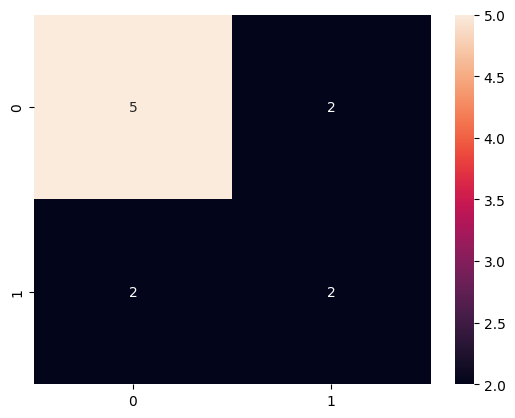

In [ ]:
# test with LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
import seaborn as sns


clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
# plot confusion matrix

# plot confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

plt.show()
